# Dynamic ecoregions

## Define inputs

In [1]:
# Inputs

input_file = "data/data-continental-united-states.csv"
# input_file = "data/data-nh-vt.csv"

geocode_precision = 4
# geocode_precision = 5

log_file = "run.log"

output_file = "output.geojson"

num_clusters = 120
# num_clusters = 3

## Set up logging

In [2]:
import logging

logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)

## Data flow

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


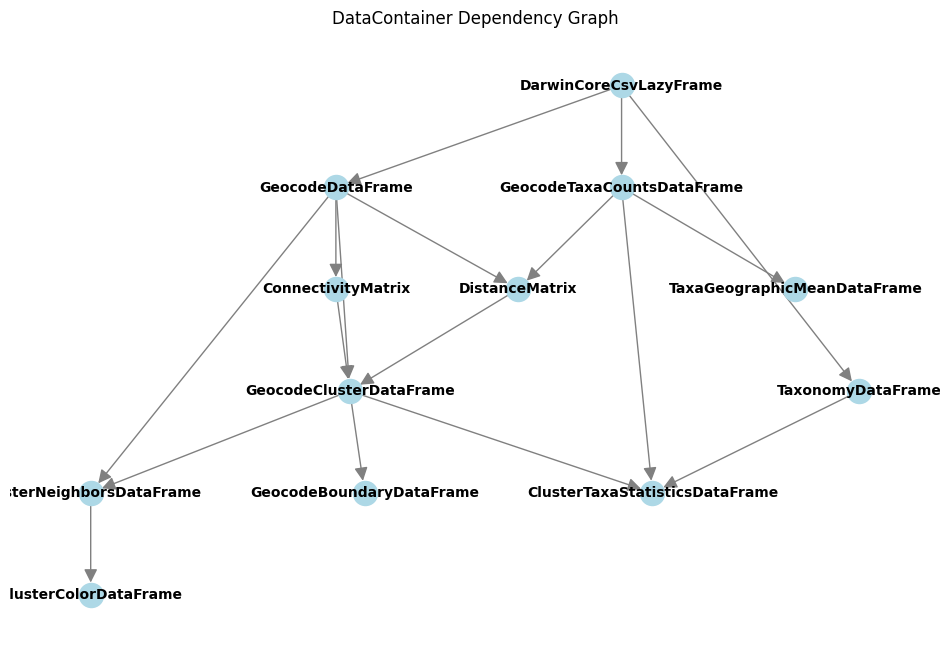

In [3]:
from src.dependency_graph import plot_dependency_graph

plot_dependency_graph()

## `DarwinCoreCsvLazyFrame`

### Build

In [4]:
from src.lazyframes.darwin_core_csv import DarwinCoreCsvLazyFrame

darwin_core_csv_lazy_frame = DarwinCoreCsvLazyFrame.build(input_file)

### Preview

In [5]:
darwin_core_csv_lazy_frame.lf.limit(3).collect()

gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
str,str,str,enum,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,u64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""4424226317""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Libellulidae""","""Sympetrum""",null,null,"""GENUS""","""Sympetrum Newman, 1833""","""Sympetrum""",null,"""US""",null,"""New York""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",42.96266,-76.740947,"""2191.0""",null,null,null,null,null,"""2019-09-06T10:30""","""6""","""9""","""2019""",1428195,null,"""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32505913""",null,"""Amy Guala""","""2019-09-11T01:33:07""","""CC_BY_NC_4_0""","""Amy Guala""","""Amy Guala""",null,null,"""2024-12-03T00:52:33.467Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423028148""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Lepidoptera""","""Geometridae""","""Nematocampa""","""Nematocampa resistaria""",null,"""SPECIES""","""Nematocampa resistaria (Herric…","""Nematocampa resistaria""",null,"""US""",null,"""Vermont""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",43.822608,-72.641412,"""5.0""",null,null,null,null,null,"""2019-09-11T22:08:52""","""11""","""9""","""2019""",1991012,"""1991012""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32566956""",null,"""bugguytad""","""2019-09-12T02:25:38""","""CC_BY_NC_4_0""","""bugguytad""","""bugguytad""",null,null,"""2024-12-03T01:38:46.617Z""","""StillImage;StillImage;StillIma…","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423041120""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Coenagrionidae""","""Argia""","""Argia moesta""",null,"""SPECIES""","""Argia moesta (Hagen, 1861)""","""Argia moesta""",null,"""US""",null,"""Texas""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",30.99463,-103.662658,null,null,null,null,null,null,"""2019-09-08T09:01""","""8""","""9""","""2019""",5051399,"""5051399""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32612673""",null,"""Todd Fitzgerald""","""2019-09-12T22:11:30""","""CC_BY_NC_4_0""","""Todd Fitzgerald""","""Todd Fitzgerald""",null,null,"""2024-12-03T01:38:10.816Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"


## `GeohashDataFrame`

### Build

In [6]:
from src.dataframes.geocode import GeocodeDataFrame

geocode_dataframe = GeocodeDataFrame.build(
    darwin_core_csv_lazy_frame,
    geocode_precision,
)

### Preview

In [7]:
geocode_dataframe.df

geocode,center,direct_neighbors,direct_and_indirect_neighbors
str,struct[2],list[str],list[str]
"""840e491ffffffff""","{49.369298,-67.913007}","[""840e497ffffffff"", ""840e493ffffffff"", ""840e49bffffffff""]","[""840e497ffffffff"", ""840e493ffffffff"", ""840e49bffffffff""]"
"""840e493ffffffff""","{48.946311,-67.83016}","[""840e49bffffffff"", ""840e491ffffffff"", … ""842b14dffffffff""]","[""840e49bffffffff"", ""840e491ffffffff"", … ""842b14dffffffff""]"
"""840e497ffffffff""","{49.104076,-68.442117}","[""840e491ffffffff"", ""840e4bbffffffff"", … ""840e493ffffffff""]","[""840e491ffffffff"", ""840e4bbffffffff"", … ""840e493ffffffff""]"
"""840e49bffffffff""","{49.208357,-67.299825}","[""842b325ffffffff"", ""840e491ffffffff"", … ""842b327ffffffff""]","[""842b325ffffffff"", ""840e491ffffffff"", … ""842b327ffffffff""]"
"""840e4b1ffffffff""","{49.410776,-69.681628}","[""840e4b7ffffffff"", ""840e4b3ffffffff"", ""840e4bbffffffff""]","[""840e4b7ffffffff"", ""840e4b3ffffffff"", ""840e4bbffffffff""]"
…,…,…,…
"""844db61ffffffff""","{31.586253,-71.677466}",[],"[""844db4dffffffff""]"
"""8450903ffffffff""","{25.536202,-120.791687}",[],"[""84486d7ffffffff""]"
"""8450997ffffffff""","{28.357494,-123.742585}",[],"[""8429265ffffffff"", ""8450aa7ffffffff""]"


## `TaxonomyDataFrame`

### Build

In [8]:
from src.dataframes.taxonomy import TaxonomyDataFrame

taxonomy_dataframe = TaxonomyDataFrame.build(darwin_core_csv_lazy_frame)

### Preview

In [9]:
taxonomy_dataframe.df

kingdom,phylum,class,order,family,genus,species,taxonRank,scientificName
enum,str,str,str,str,str,str,str,str
"""Animalia""","""Arthropoda""","""Insecta""","""Lepidoptera""","""Nymphalidae""","""Asterocampa""","""Asterocampa clyton""","""SPECIES""","""Asterocampa clyton (Boisduval …"
"""Animalia""","""Arthropoda""","""Insecta""","""Coleoptera""","""Cerambycidae""","""Graphisurus""","""Graphisurus fasciatus""","""SPECIES""","""Graphisurus fasciatus (Degeer,…"
"""Animalia""","""Arthropoda""","""Insecta""","""Hemiptera""","""Gerridae""","""Trepobates""","""Trepobates subnitidus""","""SPECIES""","""Trepobates subnitidus Esaki, 1…"
"""Animalia""","""Arthropoda""","""Insecta""","""Hemiptera""","""Cicadellidae""","""Agalliopsis""","""Agalliopsis variabilis""","""SPECIES""","""Agalliopsis variabilis Oman, 1…"
"""Animalia""","""Arthropoda""","""Insecta""","""Coleoptera""","""Scarabaeidae""","""Trichiotinus""","""Trichiotinus lunulatus""","""SPECIES""","""Trichiotinus lunulatus (Fabric…"
…,…,…,…,…,…,…,…,…
"""Animalia""","""Arthropoda""","""Insecta""","""Coleoptera""","""Cerambycidae""","""Aneflus""","""Aneflus sonoranus""","""SPECIES""","""Aneflus sonoranus Casey, 1924"""
"""Animalia""","""Arthropoda""","""Insecta""","""Coleoptera""","""Elmidae""","""Stenelmis""","""Stenelmis moapa""","""SPECIES""","""Stenelmis moapa La Rivers, 194…"
"""Animalia""","""Mollusca""","""Bivalvia""","""Venerida""","""Veneridae""","""Dosinia""",null,"""GENUS""","""Dosinia Scopoli, 1777"""


## `GeohashSpeciesCountsDataFrame`

### Build

In [10]:
from src.dataframes.geocode_taxa_counts import GeocodeTaxaCountsDataFrame

geocode_taxa_counts_dataframe = GeocodeTaxaCountsDataFrame.build(
    darwin_core_csv_lazy_frame,
    geocode_precision,
)

### Preview

In [11]:
geocode_taxa_counts_dataframe.df

geocode,kingdom,taxonRank,scientificName,count
str,enum,str,str,u32
"""840e491ffffffff""","""Animalia""","""SPECIES""","""Chlamys islandica (O.F.Müller,…",1
"""840e491ffffffff""","""Fungi""","""SPECIES""","""Amanita flavoconia G.F.Atk.""",1
"""840e491ffffffff""","""Plantae""","""SPECIES""","""Picea mariana (Mill.) Britton …",4
"""840e491ffffffff""","""Animalia""","""SPECIES""","""Melospiza lincolnii (Audubon, …",1
"""840e491ffffffff""","""Animalia""","""SPECIES""","""Pagurus arcuatus Squires, 1964""",1
…,…,…,…,…
"""844db61ffffffff""","""Animalia""","""SPECIES""","""Euchaetes egle Drury, 1773""",1
"""8450903ffffffff""","""Animalia""","""SPECIES""","""Eristalis tenax (Linnaeus, 175…",1
"""8450997ffffffff""","""Animalia""","""SPECIES""","""Larus occidentalis Audubon, 18…",1


## `ConnectivityMatrix`

### Build

In [12]:
from src.matrices.connectivity import ConnectivityMatrix

connectivity_matrix = ConnectivityMatrix.build(geocode_dataframe)

### Shape

In [13]:
connectivity_matrix._connectivity_matrix.shape

(7416, 7416)

### Preview

In [14]:
connectivity_matrix._connectivity_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

## `DistanceMatrix`

In [15]:
from src.matrices.distance import DistanceMatrix

print(DistanceMatrix.__doc__)


    A distance matrix where each column and row is a geocode, and the cell at the intersection of a
    column and row is the similarity (or distance) between the two geocodes. Internally it is stored
    as a condensed distance matrix, which is a one-dimensional array containing the upper triangular
    part of the distance matrix.
    


### Build

In [ ]:
distance_matrix = DistanceMatrix.build(
    geocode_taxa_counts_dataframe,
    geocode_dataframe,
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Shape

In [ ]:
distance_matrix.squareform().shape

### Preview

In [ ]:
distance_matrix.squareform()

## `GeohashClusterDataFrame`

### Build

In [19]:
from src.dataframes.geocode_cluster import GeocodeClusterDataFrame

geocode_cluster_dataframe = GeocodeClusterDataFrame.build(
    geocode_dataframe,
    distance_matrix,
    connectivity_matrix,
    num_clusters,
)

### Preview

In [ ]:
geocode_cluster_dataframe.df.limit(3)

In [21]:
# # TMP

# from src.dataframes.geocode_cluster import GeocodeClusterDataFrame
# from sklearn.metrics import silhouette_score

# results = []

# for i in range(2, 200):
#     geocode_cluster_dataframe = GeocodeClusterDataFrame.build(
#         geocode_dataframe,
#         distance_matrix,
#         connectivity_matrix,
#         num_clusters=i,
#     )
#     score = silhouette_score(
#         X=distance_matrix.squareform(),
#         labels=geocode_cluster_dataframe.df["cluster"],
#         metric="precomputed",
#     )
#     print(f"{i}: {score}")
#     results.append((i, score))

# results


## `ClusterNeighborsDataframe`

### Build

In [22]:
from src.dataframes.cluster_neighbors import ClusterNeighborsDataFrame

cluster_neighbors_dataframe = ClusterNeighborsDataFrame.build(
    geocode_dataframe,
    geocode_cluster_dataframe,
)

### Preview

In [ ]:
cluster_neighbors_dataframe.df

## `ClusterColorDataFrame`

### Build

In [24]:
from src.dataframes.cluster_color import ClusterColorDataFrame

cluster_colors_dataframe = ClusterColorDataFrame.build(cluster_neighbors_dataframe)

### Preview

In [ ]:
cluster_colors_dataframe.df

## `GeocodeSilhouetteScoreDataFrame`

### Build

In [26]:
from src.dataframes.geocode_silhouette_score import GeocodeSilhouetteScoreDataFrame

geocode_silhouette_score_dataframe = GeocodeSilhouetteScoreDataFrame.build(
    cluster_neighbors_dataframe,
    distance_matrix,
    geocode_cluster_dataframe,
)

### Preview

In [ ]:
geocode_silhouette_score_dataframe.df.sort(by="silhouette_score")

In [ ]:
import matplotlib.pyplot as plt
import polars as pl
import matplotlib.pyplot as plt
import numpy as np


n_clusters = len(geocode_cluster_dataframe.df["cluster"].unique())
n_geocodes = len(distance_matrix.squareform())

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 7)
# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
# ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, n_geocodes + (n_clusters + 1) * 10])

y_lower = 10
for i, cluster in enumerate(geocode_cluster_dataframe.df["cluster"].unique()):
    ith_cluster_silhouette_values = (
        geocode_silhouette_score_dataframe
        .df
        .join(geocode_cluster_dataframe.df, on="geocode")
        .filter(pl.col("cluster") == cluster)
        .sort("silhouette_score", descending=True)
    )["silhouette_score"]

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color =  cluster_colors_dataframe.get_color_for_cluster(cluster)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
    )

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples


## `ClusterTaxaStatisticsDataFrame`

### Build

In [29]:
from src.dataframes.cluster_taxa_statistics import ClusterTaxaStatisticsDataFrame

cluster_taxa_statistics_dataframe = ClusterTaxaStatisticsDataFrame.build(
    geocode_taxa_counts_dataframe,
    geocode_cluster_dataframe,
    taxonomy_dataframe,
)

### Preview

In [ ]:
cluster_taxa_statistics_dataframe.df.limit(3)

## `ClusterSignificantDifferencesDataFrame`

### Build

In [31]:
from src.dataframes.cluster_significant_differences import ClusterSignificantDifferencesDataFrame

cluster_significant_differences_dataframe = ClusterSignificantDifferencesDataFrame.build(
    cluster_taxa_statistics_dataframe,
)

### Preview

In [ ]:
cluster_significant_differences_dataframe.df.limit(3)

## `GeocodeBoundaryDataFrame`

### Build

In [33]:
from src.dataframes.geocode_boundary import GeocodeBoundaryDataFrame

geocode_boundary_dataframe = GeocodeBoundaryDataFrame.build(
    geocode_cluster_dataframe,
)

### Preview

In [ ]:
geocode_boundary_dataframe.df

## Build and plot GeoJSON feature collection

In [ ]:
from src.geojson import build_geojson_feature_collection, write_geojson
from src.render import plot_clusters
import matplotlib.pyplot as plt

# Set the figure size
plt.rcParams['figure.figsize'] = [12, 7]

feature_collection = build_geojson_feature_collection(
    geocode_boundary_dataframe,
    geocode_cluster_dataframe,
    cluster_colors_dataframe,
)

write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

## Build and display HTML output

In [ ]:
from src.html_output import build_html_output
from IPython.display import display, HTML

html = build_html_output(
    cluster_colors_dataframe,
    cluster_significant_differences_dataframe,
)

display(HTML(html))


## TSNE 2d plot

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    metric="precomputed",
    init="random",
    perplexity=min(30, distance_matrix.squareform().shape[0] - 1), # HACK FOR SMALLER DATASETS
)
X_tsne = tsne.fit_transform(distance_matrix.squareform())
tsne.kl_divergence_


In [ ]:
import umap

umap = umap.UMAP(
    n_components=2,
    metric="precomputed",
    random_state=42,
    n_neighbors=3000,
    # min_dist=1,
    # init="random",
)
X_umap = umap.fit_transform(distance_matrix.squareform())


In [ ]:
import seaborn as sns

sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=geocode_cluster_dataframe.df["cluster"],
    palette=cluster_colors_dataframe.to_dict(),
    alpha=1,
)

## Clustermap visualization

In [ ]:
import seaborn as sns
import polars as pl
from scipy.cluster.hierarchy import linkage


linkage_array = linkage(distance_matrix.condensed(), "ward")

ordered_geocodes = geocode_dataframe.df["geocode"].unique()

def min_max_normalize(series: pl.Series) -> pl.Series:
    return (series - series.min()) / (series.max() - series.min())

col_colors = []
for geocode in ordered_geocodes:
    cluster = geocode_cluster_dataframe.cluster_for_geocode(geocode)
    col_colors.append(cluster_colors_dataframe.get_color_for_cluster(cluster))

data = {}
for species, kingdom, taxonRank in cluster_significant_differences_dataframe.df.select("scientificName", "kingdom", "taxonRank").unique().iter_rows():
    counts = []

    for geocode in ordered_geocodes:
        geocode_counts_species = geocode_taxa_counts_dataframe.df.filter(
            pl.col("geocode") == geocode, pl.col("scientificName") == species
        ).get_column("count").sum()
        geocode_counts_all = geocode_taxa_counts_dataframe.df.filter(
            pl.col("geocode") == geocode
        ).get_column("count").sum()
        geocode_average = geocode_counts_species / geocode_counts_all
        all_average = (
            cluster_taxa_statistics_dataframe.df.filter(
                pl.col("kingdom") == kingdom,
                pl.col("scientificName") == species,
                pl.col("cluster").is_null(),
                pl.col("taxonRank") == taxonRank,
            )
            .get_column("average")
            .item()
        )
        counts.append(geocode_average - all_average)
    counts = pl.Series(
        values=counts,
        name=species,
    )
    # counts = counts / counts.max()
    # counts = counts.pow(1 / 3)
    data[species] = min_max_normalize(counts)


In [ ]:
dataframe = pl.DataFrame(data=data)
sns.clustermap(
    data=dataframe,
    col_cluster=False,
    row_cluster=True,
    row_linkage=linkage_array,
    row_colors=col_colors,
    xticklabels=dataframe.columns,
    yticklabels=False,
)